In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend

### Note! Change in import and function from video recording

Due to changes in packages since the recording of the video, two changes have been made in this notebook to reflect changes:

At 0:09, the video shows the import block. the line `from ts_helper import *` is not needed, and has been replaced by the line `from statsmodels.tsa.seasonal import _extrapolate_trend`

At 3:20 the `extrapolate_trend()` is used. Please use `_extrapolate_trend()` instead (notice the leading underscore).

# Load sunspots data

<Axes: xlabel='Date'>

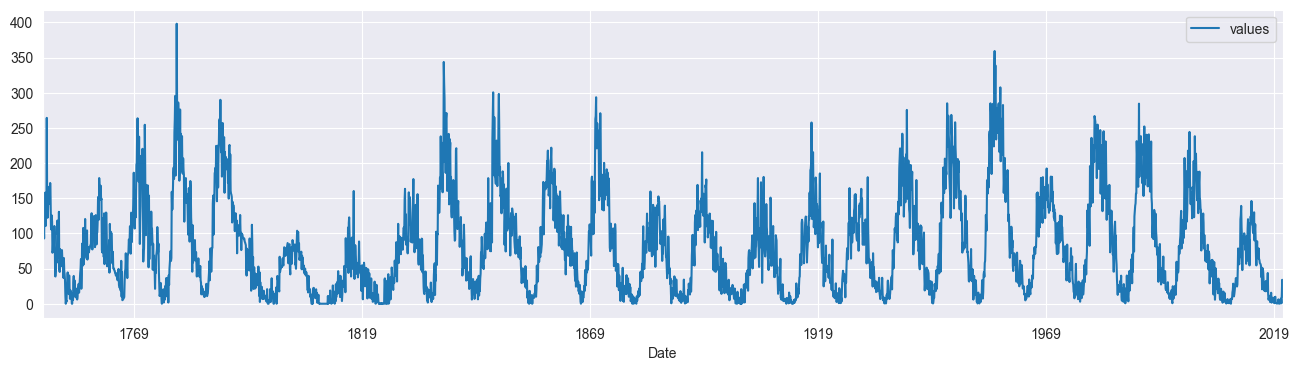

In [2]:
sunspots = pd.read_csv('data/Sunspots.csv')
sunspots = sunspots.set_index(pd.to_datetime(sunspots['Date'])).drop(columns=['Unnamed: 0','Date']).rename(columns={'Monthly Mean Total Sunspot Number':'values'})

sunspots.plot(figsize=(16,4))

In [3]:
sunspots

,values
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


# Split historical and future data

In [4]:
y_hist = sunspots.loc['1900':'1984','values']
y_future = sunspots.loc['1985':'2000','values']

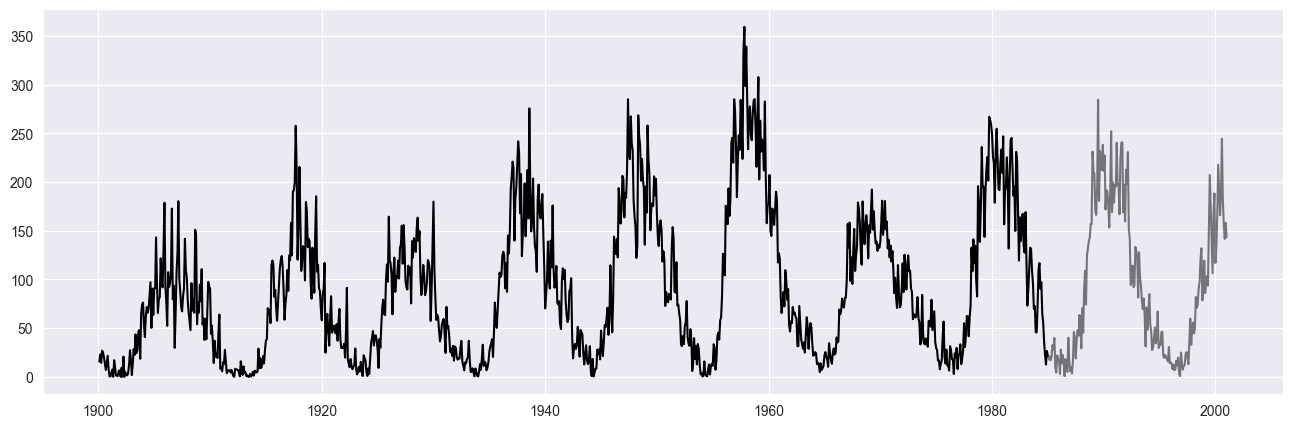

In [5]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)

# Extract the trend

Since you know the period for solar sunspots is about 128 months, you can give the filter a length 129 (period+1).

In [6]:
period = 128
# coefficients of the filter
filt = np.ones(period+1) # period of 129
filt[0] = 0.5
filt[-1] = 0.5
filt /= period
sum(filt) # the sum of all coefficients of the filter, must be 1, the mean of historical data not to be affected

1.0

In [7]:
# Once you have the filter, you can run the historical data through the filter to extrapolate the trend.
trend = convolution_filter(y_hist, filt)

# trend is not going all the way to the beginning or to the end of the historical period, so it needs to be extrapolated to reach the end
trend = _extrapolate_trend(trend, period + 1)

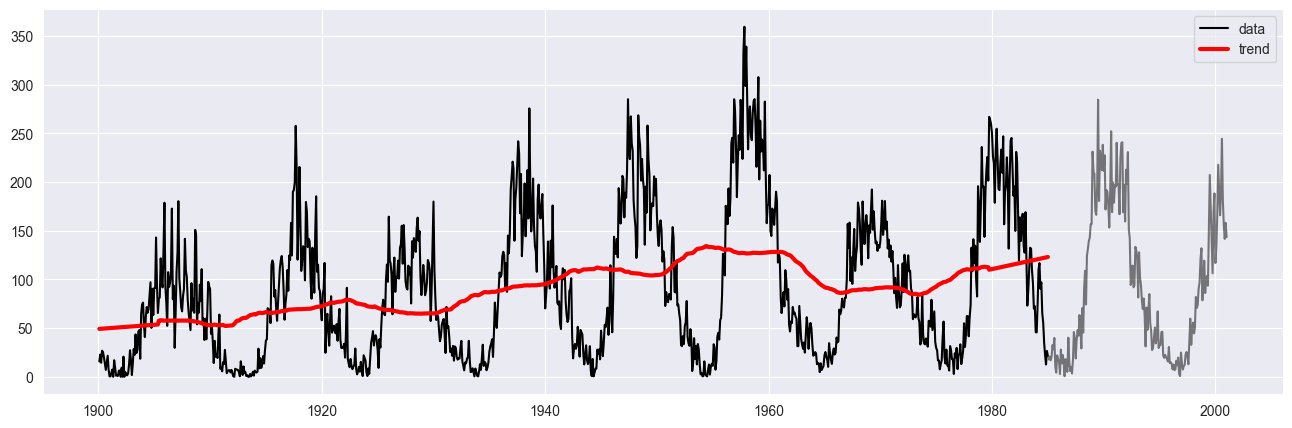

In [8]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_future,'k',alpha=0.5)
plt.legend()

# Detrended data - the mean is ZERO now
The detrended data is similar to the historical data, except that the mean is at zero.

In [9]:
detrended = y_hist - trend
detrended = detrended.to_numpy()
np.mean(detrended)

0.43177981985038644

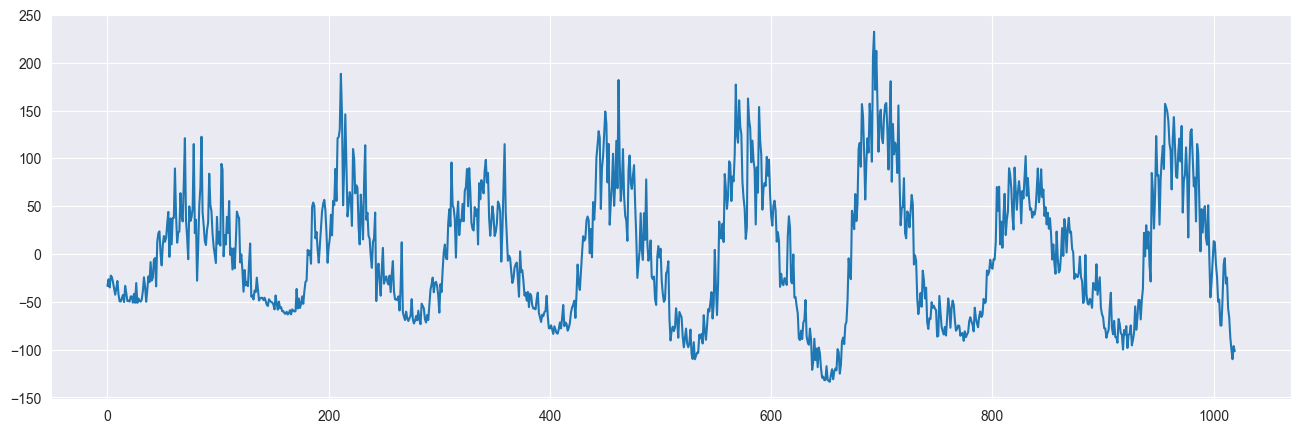

In [10]:
plt.figure(figsize=(16,5))
plt.plot(detrended)

# Split the historical data into seasons

In [11]:
lows_index = [20,155,284,405,529,650,775,917]
lows = y_hist.index[lows_index]
lows

DatetimeIndex(['1901-09-30', '1912-12-31', '1923-09-30', '1933-10-31',
               '1944-02-29', '1954-03-31', '1964-08-31', '1976-06-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

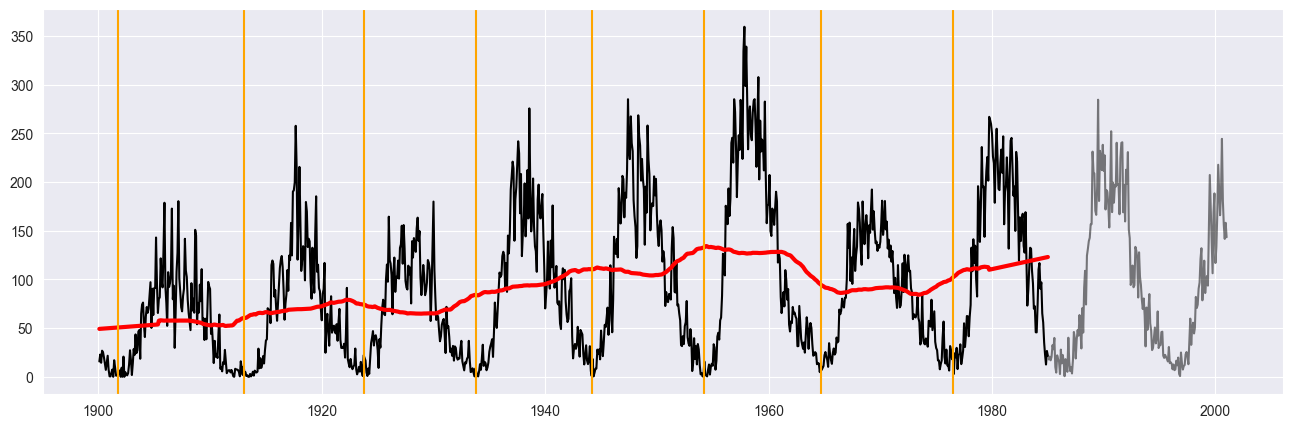

In [12]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange') # with the axvline() function you create vertical lines through the low points.

# Divide the detrended data into seasons
it is important to have a common period for every season so you can store the data in a matrix

In [13]:
period = int(np.round(np.mean(np.diff(lows_index))))

#the number of seasons is the number of orange bars, minus one.(128 – 1)
num_seasons = len(lows)-1

In [14]:
seasonals = np.empty((period,num_seasons)) # 128 x 7
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))   # normalise data and multiply by two
    seasonals[:,p] = s                          # metrics
    
# to extract the mean of the seasons    
mean_seasonals = seasonals.mean(axis=1) 
seasonals.shape

(128, 7)

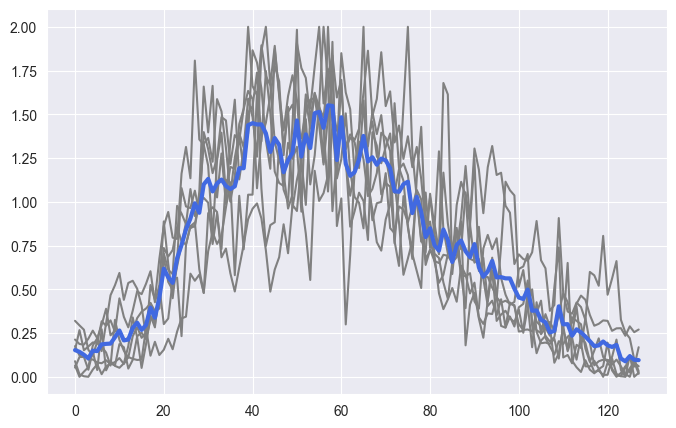

In [15]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Smooth the seasonal data

In [16]:
# create a filter
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = convolution_filter(s, filt) #scale it
    s = _extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

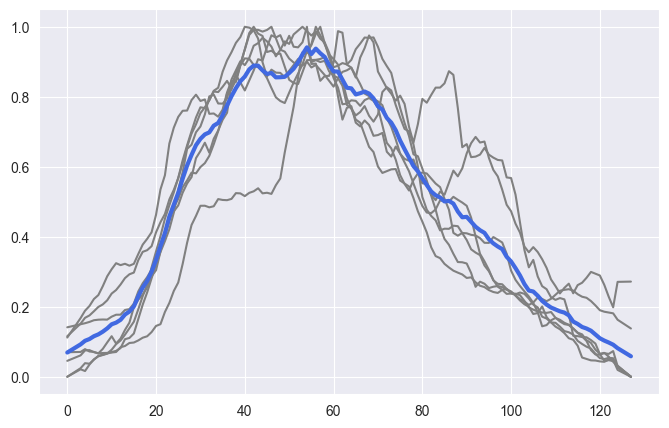

In [17]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Remove outliers

In [18]:
seasonals = seasonals[:,[2,3,4]] # 0, 1,5 are outliers
mean_seasonals = seasonals.mean(axis=1)

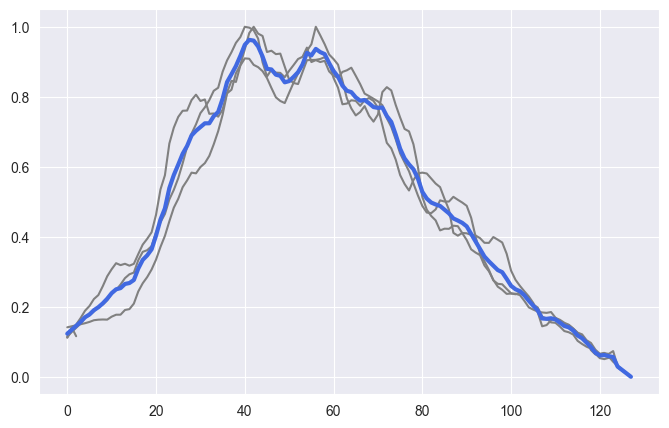

In [19]:
plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Build the seasonal template
You construct a series whose index is the same as the historical dates. 
And you set all the data to zero. 
And then copy into that index the mean_seasonals, as much as will fit.

In [20]:
seasonal = pd.Series(index=y_hist.index,data=0)

for low in lows_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

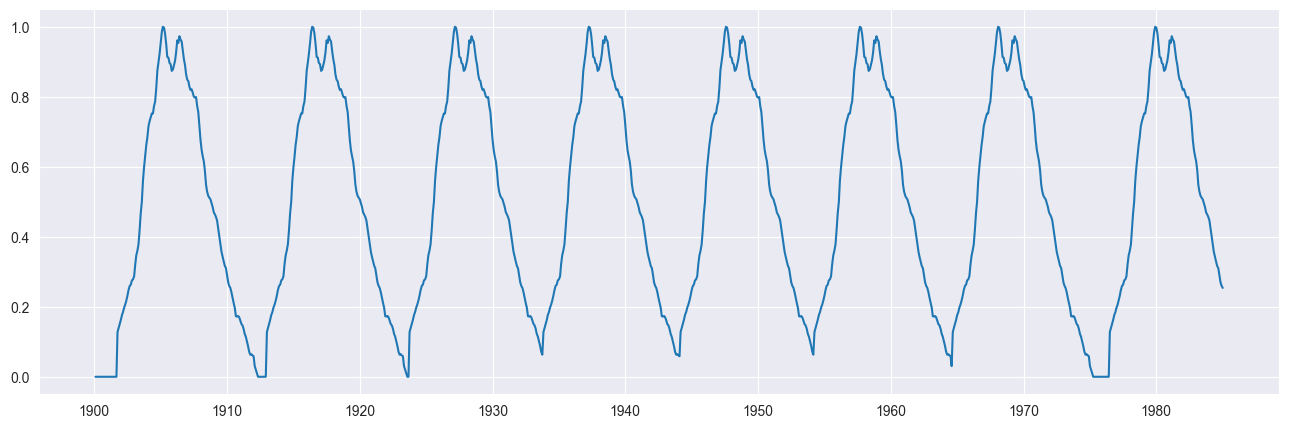

In [21]:
plt.figure(figsize=(16,5))
plt.plot(seasonal)

# Final model

In [22]:
season_and_trend = 2*trend*seasonal

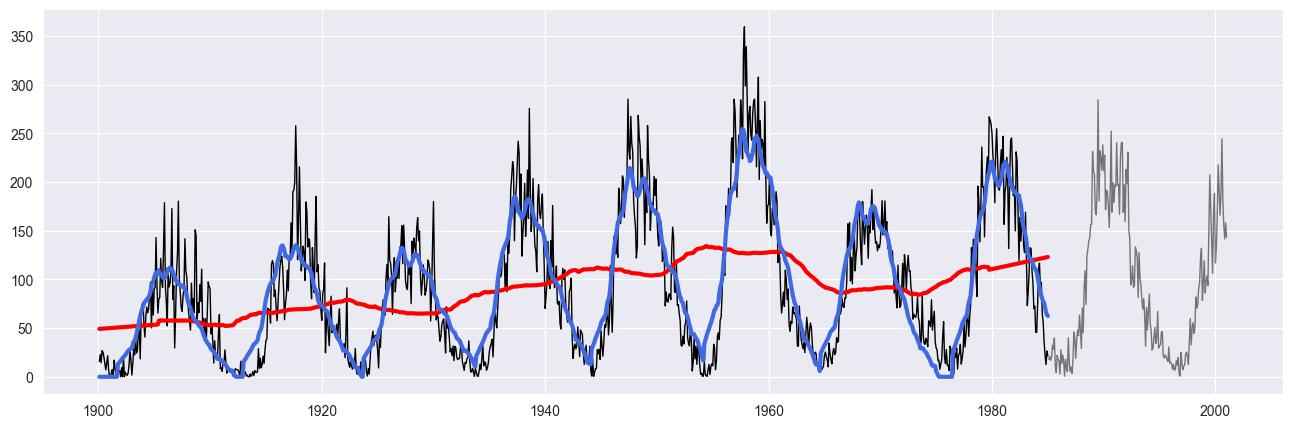

In [23]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)

# Model residue
computing the residue, which is the difference between the historical data and the model

In [24]:
residue = y_hist - season_and_trend

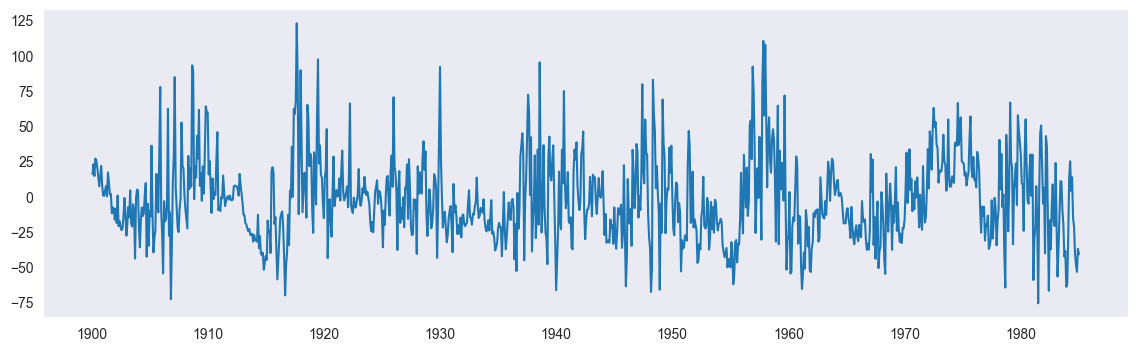

In [25]:
plt.figure(figsize=(14,4))
plt.plot(residue)
plt.grid()

## Size of the residue


In [26]:
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt( np.square(residue).mean() )
MAEm, RMSEm

(22.72635908805391, 29.218041541672687)

## Stationarity of the residue
The module shows that is not stationary at this shape
If the residue were stationary, you would expect it to decay or maybe just cut off at some point.
But it is not decaying exponentially, which is indicative of non-stationarity.

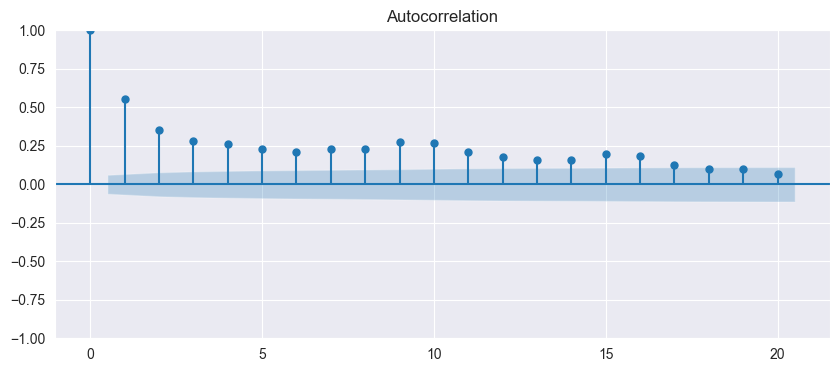

In [27]:
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(residue,lags=20, ax=ax)
plt.show()

# Forecast

In [28]:
f = len(y_future)
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_future.index, data=trend[-1]) # project the trend forward

In [29]:
yhat_seasonal = pd.Series(index=y_future.index)
# go step-by-step through the future  loop and copy in the value from the seasonal
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]

C:\Users\Plamen\AppData\Local\Temp\ipykernel_30472\3998046725.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yhat_seasonal = pd.Series(index=y_future.index)


In [30]:
# Forcast model
yhat = 2*yhat_trend*yhat_seasonal

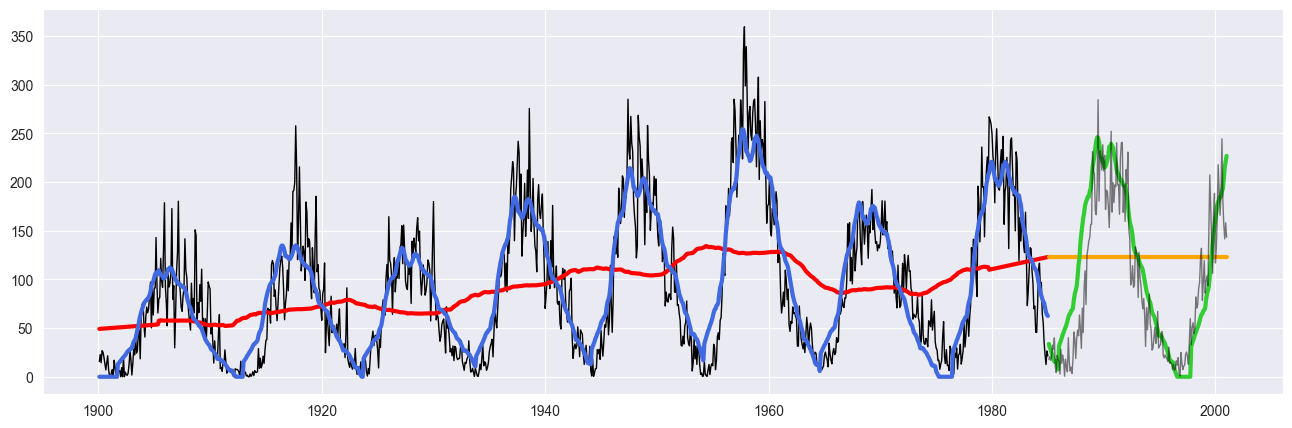

In [31]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)

## Prediction error
Once you computed the prediction error, you can put it into the same plot as the residuals.
Residual plot with error in pink
the prediction error can be computed by subtracting the forecast from the observed data.

In [32]:
pred_error = y_future - yhat # yhat model or forcast

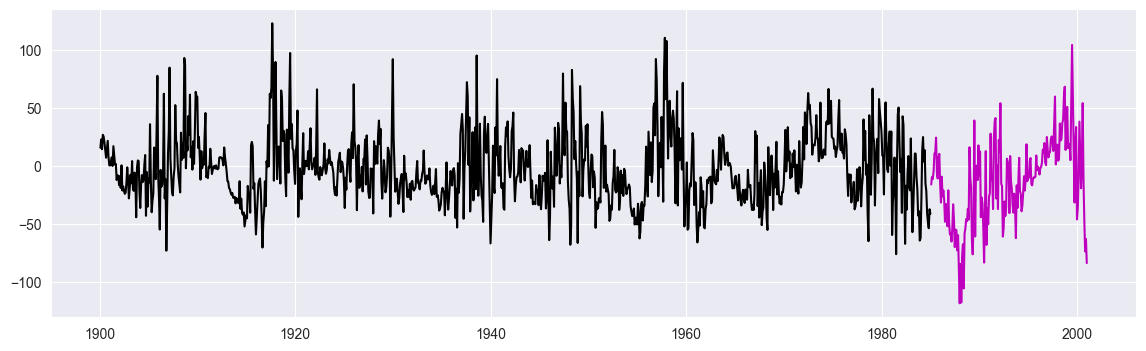

In [33]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k')
plt.plot(pred_error,'m')

## Size of the prediction error

Now if you compare that to the metrics for the residual, which are 22 and 29, it is evident that they are quite a bit larger and that is very reasonable.
It is like saying that the error in the testing dataset is larger than the error in the training dataset. 
Which is what you would expect, since the training was done, in a way, to minimize the error. So this is all very reasonable.

In [34]:
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
MAEp, RMSEp

(30.579767206745913, 39.01253619725412)

# save the result

In [35]:
import pickle

X = { 'history' : pd.DataFrame({'y_hist':y_hist ,'t_and_s':season_and_trend ,'ts_residue':residue}),
      'future': pd.DataFrame({'y_future':y_future , 'y_hat':yhat })
}
    
with open('decomp.pkl', 'wb') as file:
    pickle.dump(X,file)